In [23]:
import pandas as pd
import pdb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from mcap.reader import make_reader
from mcap_ros2.decoder import DecoderFactory
from mcap.well_known import MessageEncoding, SchemaEncoding
from mcap.records import Message, Schema
from mcap_ros2.reader import read_ros2_messages
import matplotlib.ticker as ticker
import os
import glob
from tabulate import tabulate
import matplotlib.pyplot as plt

In [24]:
"""
Global variables: change by setiing differnt fps. windows lengh 

"""

#Sensor config
FPS_ERROR = 5/100 # percentage 
SENSOR_FPS = 20 
sensor_delay = 1/SENSOR_FPS
window_seconds = 15 

# Define expected fps per topic
expected_fps = {
    '/cam1':   20,   #20 fps * 60s = 1200 frames
    '/cam2':   20,
    '/robin':  20,
    '/falcon': 20
}

In [25]:
def time_window(stamps, start_ts, end_ts):
    """
    Returns all timestamps within the provided time window. This function is necessary because
    not all topics start sending at the same time, probably due to different starting times.

    Args:
        stamps (dict): A dictionary with the topic name as keys and list of timestamps as values
        start_ts (datetime): The start of the time window
        end_ts (datetime): The end of the time window
    Returns:
        dict[str, np.array(datetime)]: Dictionary with all timestamps in a certain window for each topic
    """
    window_stamps = {}
    for topic in stamps:
        # cast list of timestamps to np.array
        topic_stamps = np.array(stamps[topic])

        # use only timestamps within the provided window
        mask = (topic_stamps >= start_ts) & (topic_stamps < end_ts)
        window_stamps[topic] = topic_stamps[mask]

    return window_stamps

In [26]:
# Define topics of interest
topics = ["/cam1", "/cam2", "/robin", "/falcon"]

# Find all .mcap files in the current directory
base_dir = os.getcwd()
mcap_files = glob.glob(os.path.join(base_dir, "*.mcap"))

if not mcap_files:
    raise FileNotFoundError("No .mcap files found in this directory!")

# Duration of the time window
window_duration = timedelta(seconds=window_seconds)

for mcap_file in mcap_files:
    print(f"\n📂 Processing file: {os.path.basename(mcap_file)}")

    stamps = {t: [] for t in topics}

    # Read messages
    with open(mcap_file, "rb") as f:
        reader = make_reader(f, decoder_factories=[DecoderFactory()])

        for schema, channel, message, decoded_message in reader.iter_decoded_messages():
            if channel.topic in topics:
                seconds = decoded_message.header.stamp.sec
                nanoseconds = decoded_message.header.stamp.nanosec
                ts = datetime.fromtimestamp(seconds) + timedelta(microseconds=nanoseconds / 1000)
                stamps[channel.topic].append(ts)

    # Summarize & window each topic
    for topic, ts in stamps.items():
        print(f"\nTopic: {topic}")
        if not ts:
            print("  ⚠️ No messages found")
            continue

        start_time = ts[0]
        end_time = start_time + window_duration
        windowed_ts = [t for t in ts if start_time <= t <= end_time]

        # Length of the full message timeline
        total_length = ts[-1] - ts[0]

        print(f"  Total messages in the bag: {len(ts)}")
        print(f"  Full timeline length: {total_length}")
        print(f"  Window start:  {start_time}")
        print(f"  Window end:    {end_time}")
        print(f"  Window length: {window_duration}")
        #print(f"  Messages in 1s window: {len(windowed_ts)}")


📂 Processing file: rosbag2_2025_11_14-15_03_34_0.mcap

Topic: /cam1
  Total messages in the bag: 134
  Full timeline length: 0:00:06.650002
  Window start:  2025-11-14 16:03:33.136302
  Window end:    2025-11-14 16:03:48.136302
  Window length: 0:00:15

Topic: /cam2
  Total messages in the bag: 134
  Full timeline length: 0:00:06.650023
  Window start:  2025-11-14 16:03:33.119304
  Window end:    2025-11-14 16:03:48.119304
  Window length: 0:00:15

Topic: /robin
  Total messages in the bag: 134
  Full timeline length: 0:00:06.650078
  Window start:  2025-11-14 16:03:34.999983
  Window end:    2025-11-14 16:03:49.999983
  Window length: 0:00:15

Topic: /falcon
  Total messages in the bag: 134
  Full timeline length: 0:00:06.650155
  Window start:  2025-11-14 16:03:35.001150
  Window end:    2025-11-14 16:03:50.001150
  Window length: 0:00:15


In [27]:
print(f"FPS_ERROR = {FPS_ERROR:.5f} ({FPS_ERROR*100:.2f}%)")
print(f"Global configuration: SENSOR_FPS = {SENSOR_FPS} Hz, Delay = {sensor_delay:.4f}s\n")

table_data = []

for topic in stamps:
    timestamps = np.array(stamps[topic])
    freq = len(timestamps) / (timestamps.max() - timestamps.min()).total_seconds()
    
    # Get expected fps for this topic
    topic_expected_fps = expected_fps.get(topic, SENSOR_FPS)
    
    # Calculate ±5% bounds
    lower_bound = topic_expected_fps * (1 - FPS_ERROR)
    upper_bound = topic_expected_fps * (1 + FPS_ERROR)
    
    # Check if within tolerance
    if lower_bound <= freq <= upper_bound:
        status = "✅ OK"
    else:
        status = "⚠️ WARNING"
    
    # Add formatted expected range with ± notation
    expected_str = (
        f"{topic_expected_fps:.2f} ({lower_bound:.2f}–{upper_bound:.2f}) = "
        f"{topic_expected_fps:.0f} ± {FPS_ERROR*100:.0f}%"
    )
    
    # Keep full precision for calculated frequency
    table_data.append([
        topic,
        freq,  # full number
        expected_str,
        status
    ])

headers = ["Topic", "Calculated Frequency (Hz)", "Expected Frequency Range (Hz)", "Status"]
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

FPS_ERROR = 0.05000 (5.00%)
Global configuration: SENSOR_FPS = 20 Hz, Delay = 0.0500s

╒═════════╤═════════════════════════════╤═════════════════════════════════╤══════════╕
│ Topic   │   Calculated Frequency (Hz) │ Expected Frequency Range (Hz)   │ Status   │
╞═════════╪═════════════════════════════╪═════════════════════════════════╪══════════╡
│ /cam1   │                     20.1504 │ 20.00 (19.00–21.00) = 20 ± 5%   │ ✅ OK    │
├─────────┼─────────────────────────────┼─────────────────────────────────┼──────────┤
│ /cam2   │                     20.1503 │ 20.00 (19.00–21.00) = 20 ± 5%   │ ✅ OK    │
├─────────┼─────────────────────────────┼─────────────────────────────────┼──────────┤
│ /robin  │                     20.1501 │ 20.00 (19.00–21.00) = 20 ± 5%   │ ✅ OK    │
├─────────┼─────────────────────────────┼─────────────────────────────────┼──────────┤
│ /falcon │                     20.1499 │ 20.00 (19.00–21.00) = 20 ± 5%   │ ✅ OK    │
╘═════════╧═════════════════════════════╧══════

In [28]:
start_ts = start_time
end_ts = end_time
window_stamps = time_window(stamps, start_ts, end_ts)


In [29]:
# Calculate window length in seconds
window_stamps = time_window(stamps, start_ts, end_ts)
window_length = (end_ts - start_ts).total_seconds()

# --- Formula explanation ---
print("Formula: Expected = FPS × window_length [s]")
print(f"Window length = {window_length:.2f} s\n")

# --- Collect table data ---
rows = []
for topic in window_stamps:
    f_exp = expected_fps[topic]
    n_expected = f_exp * window_length
    n_actual = len(window_stamps[topic])
    loss_percent = (n_expected - n_actual) / n_expected * 100

    rows.append([
        topic,
        f_exp,
        f"{n_expected:.0f}",
        n_actual,
        f"{loss_percent:.2f}%",
    ])

# --- Display table ---
print(tabulate(
    rows,
    headers=["Topic", "FPS", "Expected Frames", "Actual Frames", "Frame Loss (%)"],
    tablefmt="fancy_grid"
))


Formula: Expected = FPS × window_length [s]
Window length = 15.00 s

╒═════════╤═══════╤═══════════════════╤═════════════════╤══════════════════╕
│ Topic   │   FPS │   Expected Frames │   Actual Frames │ Frame Loss (%)   │
╞═════════╪═══════╪═══════════════════╪═════════════════╪══════════════════╡
│ /cam1   │    20 │               300 │              96 │ 68.00%           │
├─────────┼───────┼───────────────────┼─────────────────┼──────────────────┤
│ /cam2   │    20 │               300 │              96 │ 68.00%           │
├─────────┼───────┼───────────────────┼─────────────────┼──────────────────┤
│ /robin  │    20 │               300 │             133 │ 55.67%           │
├─────────┼───────┼───────────────────┼─────────────────┼──────────────────┤
│ /falcon │    20 │               300 │             134 │ 55.33%           │
╘═════════╧═══════╧═══════════════════╧═════════════════╧══════════════════╛


In [30]:
import matplotlib.pyplot as plt

# --- Prepare data ---
topics = []
expected_frames = []
actual_frames = []
loss_percentages = []

window_stamps = time_window(stamps, start_ts, end_ts)
window_length = (end_ts - start_ts).total_seconds()

for topic in window_stamps:
    f_exp = expected_fps[topic]
    n_expected = f_exp * window_length
    n_actual = len(window_stamps[topic])
    loss_percent = (n_expected - n_actual) / n_expected * 100

    topics.append(topic)
    expected_frames.append(n_expected)
    actual_frames.append(n_actual)
    loss_percentages.append(loss_percent)

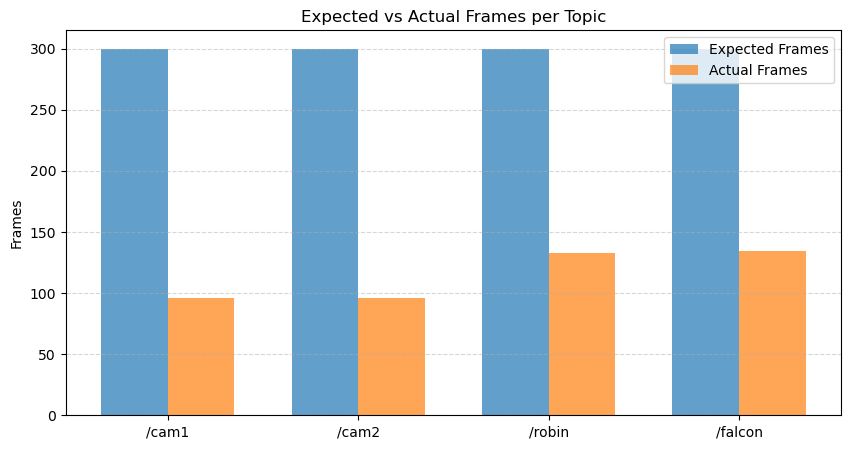

In [31]:
# --- Plot: Actual vs Expected Frames ---
plt.figure(figsize=(10,5))
bar_width = 0.35
x = range(len(topics))

plt.bar(x, expected_frames, width=bar_width, label='Expected Frames', alpha=0.7)
plt.bar([i + bar_width for i in x], actual_frames, width=bar_width, label='Actual Frames', alpha=0.7)

plt.xticks([i + bar_width/2 for i in x], topics)
plt.ylabel('Frames')
plt.title('Expected vs Actual Frames per Topic')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

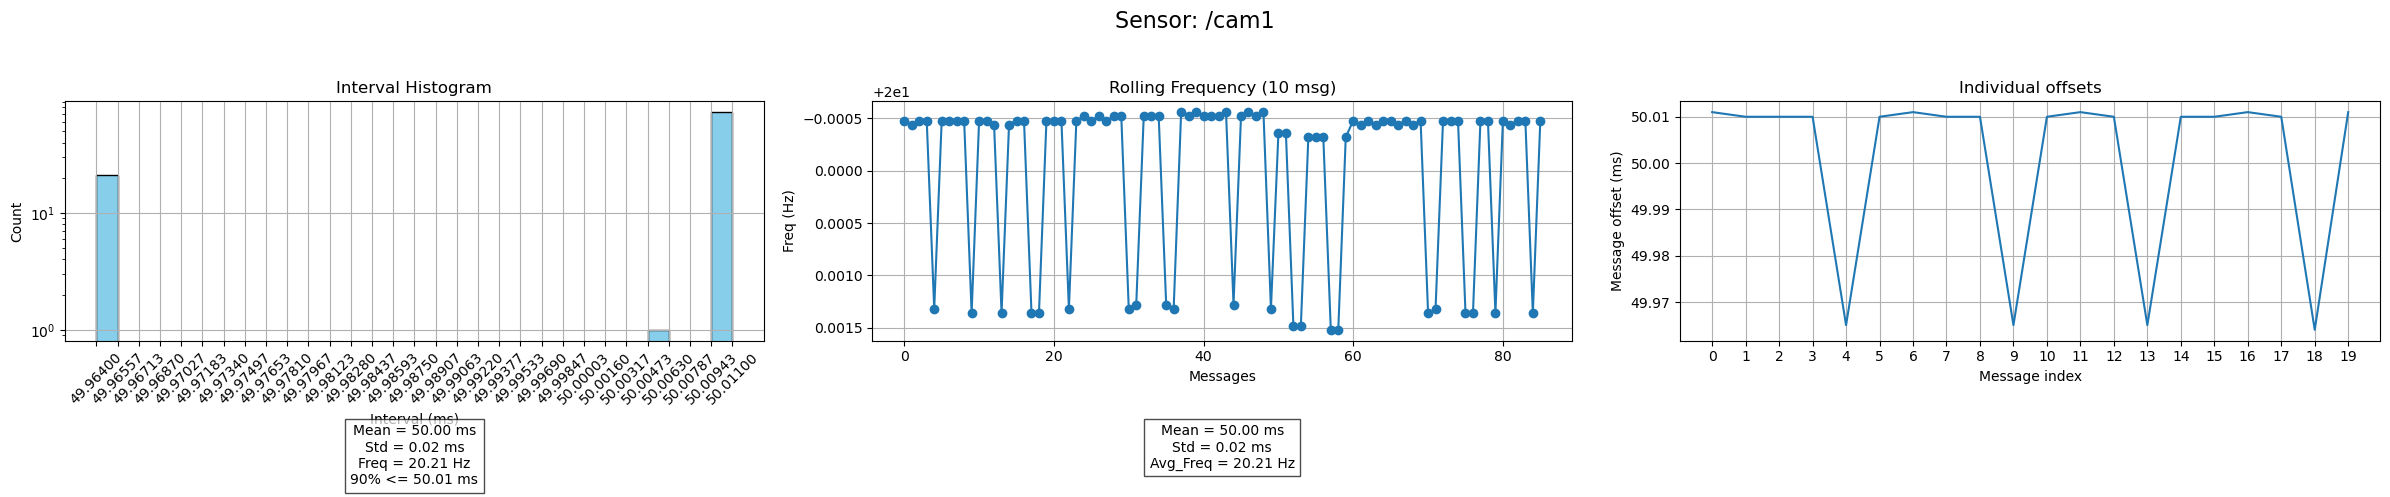

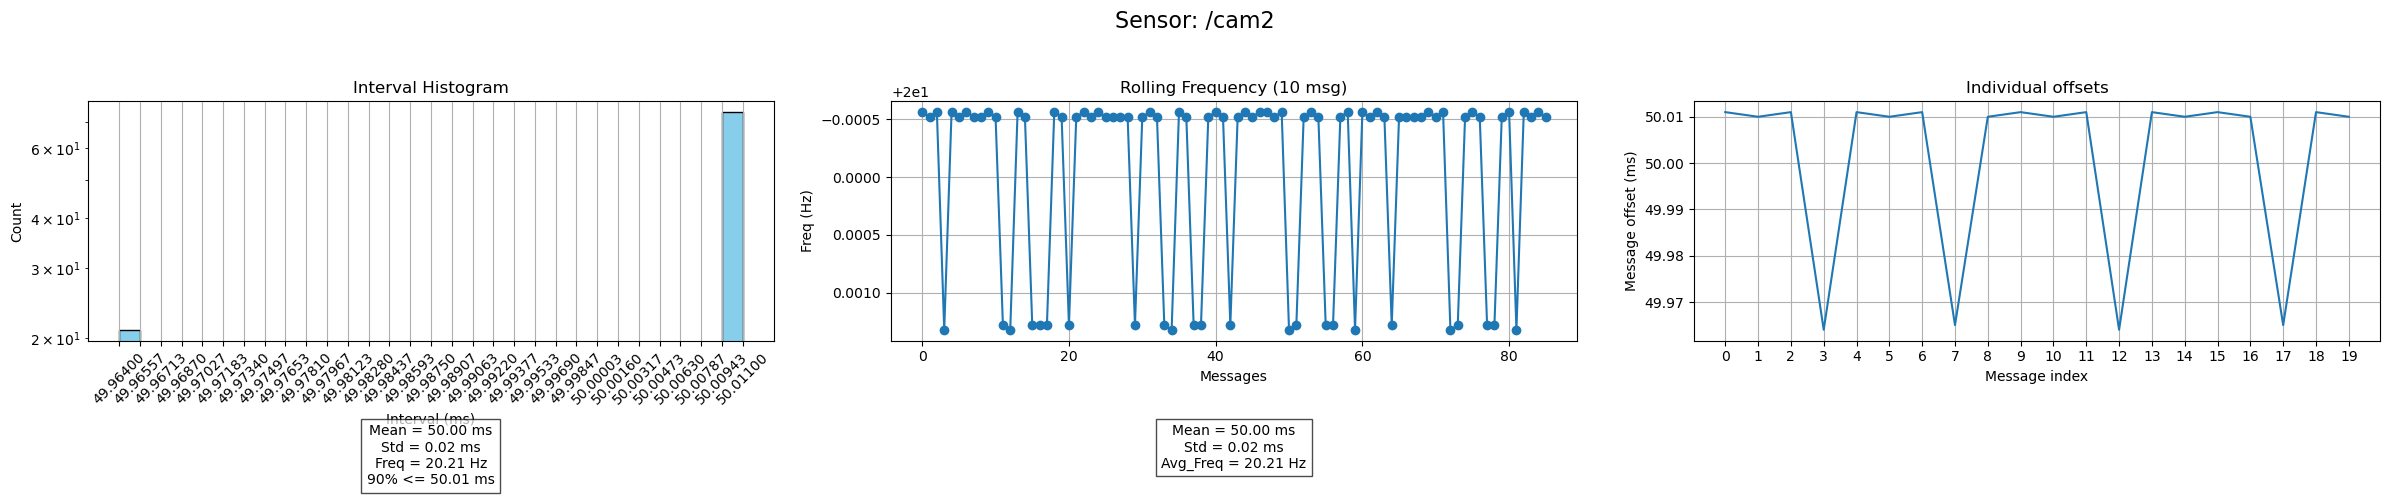

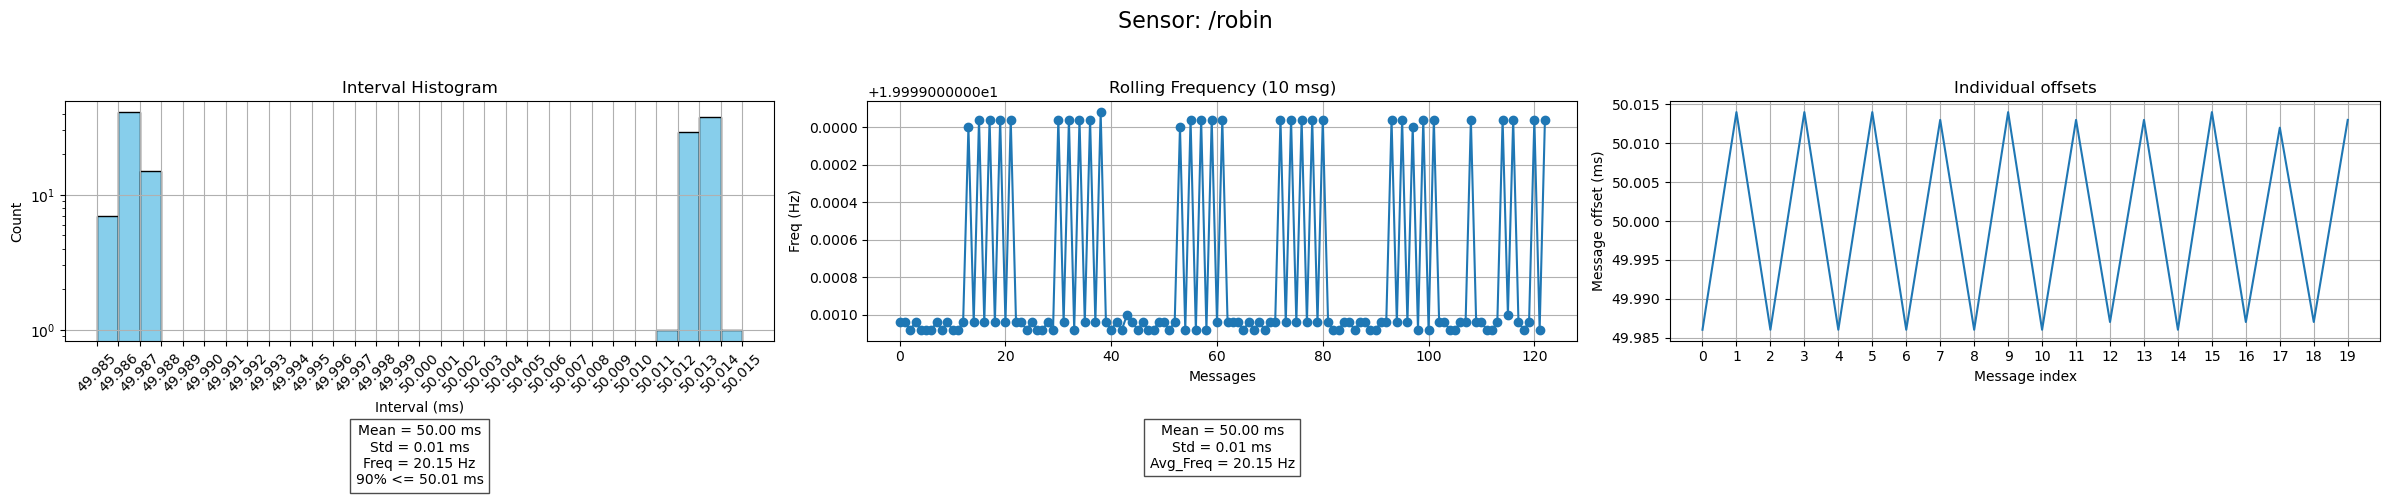

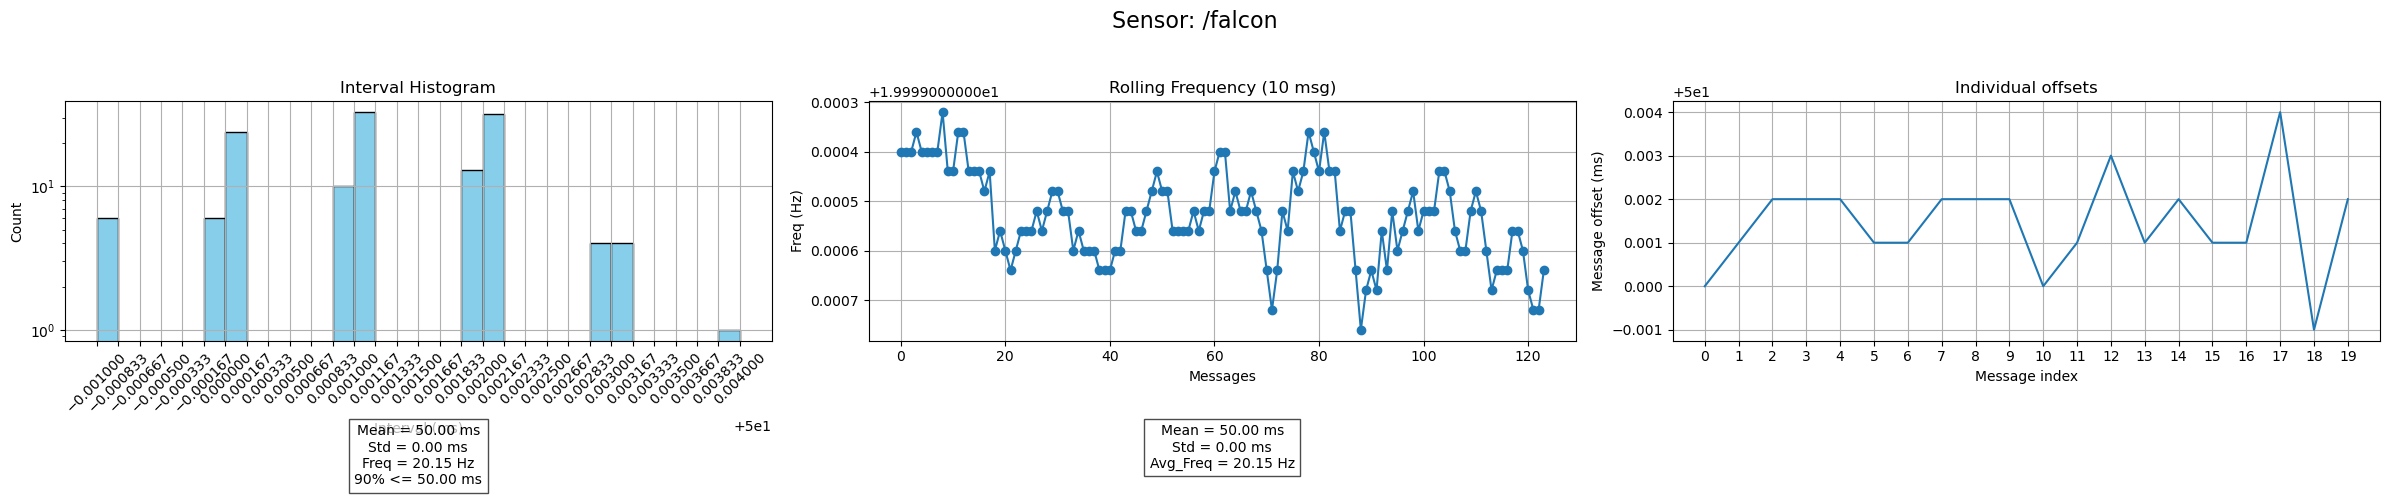

In [32]:
for topic, ts_list in window_stamps.items():
    timestamps = np.array(ts_list)

    #index_to_remove = 3  # for example, remove the 4th element
    #timestamps = np.delete(timestamps, index_to_remove)
    
    # Convert to milliseconds relative to the first message
    timestamps_ms = np.array([(t - timestamps[0]).total_seconds() * 1000 for t in timestamps])
    
    # Compute inter-message intervals in ms
    deltas = np.diff(timestamps_ms)
    
    # Basic stats
    mean_delta = np.mean(deltas) if len(deltas) > 0 else 0
    std_delta = np.std(deltas) if len(deltas) > 0 else 0
    freq = len(timestamps) / ((timestamps_ms[-1] - timestamps_ms[0])/1000) if len(timestamps) > 1 else 0  # Hz
    
    # CDF calculation
    counts, bin_edges = np.histogram(deltas, bins=30)
    cdf = np.cumsum(counts) / np.sum(counts) * 100
    
    # Percentiles
    percentiles = [90]
    percentile_values = []
    for p in percentiles:
        idx = np.searchsorted(cdf, p)
        interval_value = bin_edges[idx+1] if idx+1 < len(bin_edges) else bin_edges[-1]
        percentile_values.append(interval_value)
    
    # --- Create 3 plots in 1 row ---
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    
    # 1. Histogram of intervals
    if len(deltas) > 0:
        counts, bins, patches = ax[0].hist(deltas, bins=30, color='skyblue', edgecolor='black')
    else:
        ax[0].text(0.5, 0.5, "No data", ha='center', va='center', fontsize=14, color='red')
    ax[0].set_xticks(bins)
    ax[0].set_title("Interval Histogram")
    ax[0].set_xlabel("Interval (ms)")
    ax[0].set_ylabel("Count")
    ax[0].grid(True)
    ax[0].set_yscale('log')
    ax[0].text(0.5, -0.35, f"Mean = {mean_delta:.2f} ms\nStd = {std_delta:.2f} ms\nFreq = {freq:.2f} Hz\n90% <= {percentile_values[0]:.2f} ms",
               transform=ax[0].transAxes, ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    for label in ax[0].get_xticklabels():
       label.set_rotation(45)
    #print(f"{topic} - Histogram: Mean = {mean_delta:.2f} ms, Std = {std_delta:.2f} ms, Freq = {freq:.2f} Hz, 90% <= {percentile_values[0]:.2f} ms")

    
    # 2. Rolling frequency over 10 messages
    if len(deltas) >= 10:
        rolling_freq = 1000 / np.convolve(deltas, np.ones(10)/10, mode='valid')  # Hz
        ax[1].plot(rolling_freq, marker='o', linestyle='-')  # swapped axes
    else:
        ax[1].text(0.5, 0.5, "Not enough data", ha='center', va='center', fontsize=14, color='red')
    
    ax[1].set_title("Rolling Frequency (10 msg)")
    ax[1].set_xlabel("Messages")  # swapped label
    ax[1].set_ylabel("Freq (Hz)")  # swapped label
    ax[1].grid(True)
    ax[1].text(0.5, -0.35, f"Mean = {mean_delta:.2f} ms\nStd = {std_delta:.2f} ms\nAvg_Freq = {freq:.2f} Hz",
               transform=ax[1].transAxes, ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    ax[1].yaxis.set_inverted(True)

     # 3. 
    n = 20 # number of messages to plot
    deltas_to_plot = deltas[:n]
    x = np.arange(len(deltas_to_plot))  # x length matches y
    ax[2].plot(x, deltas_to_plot)
    ax[2].set_xticks(x)
    ax[2].set_xlabel('Message index')
    ax[2].set_ylabel('Message offset (ms)')
    ax[2].grid(True)
    ax[2].set_title("Individual offsets")


    # Layout
    plt.suptitle(f"Sensor: {topic}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


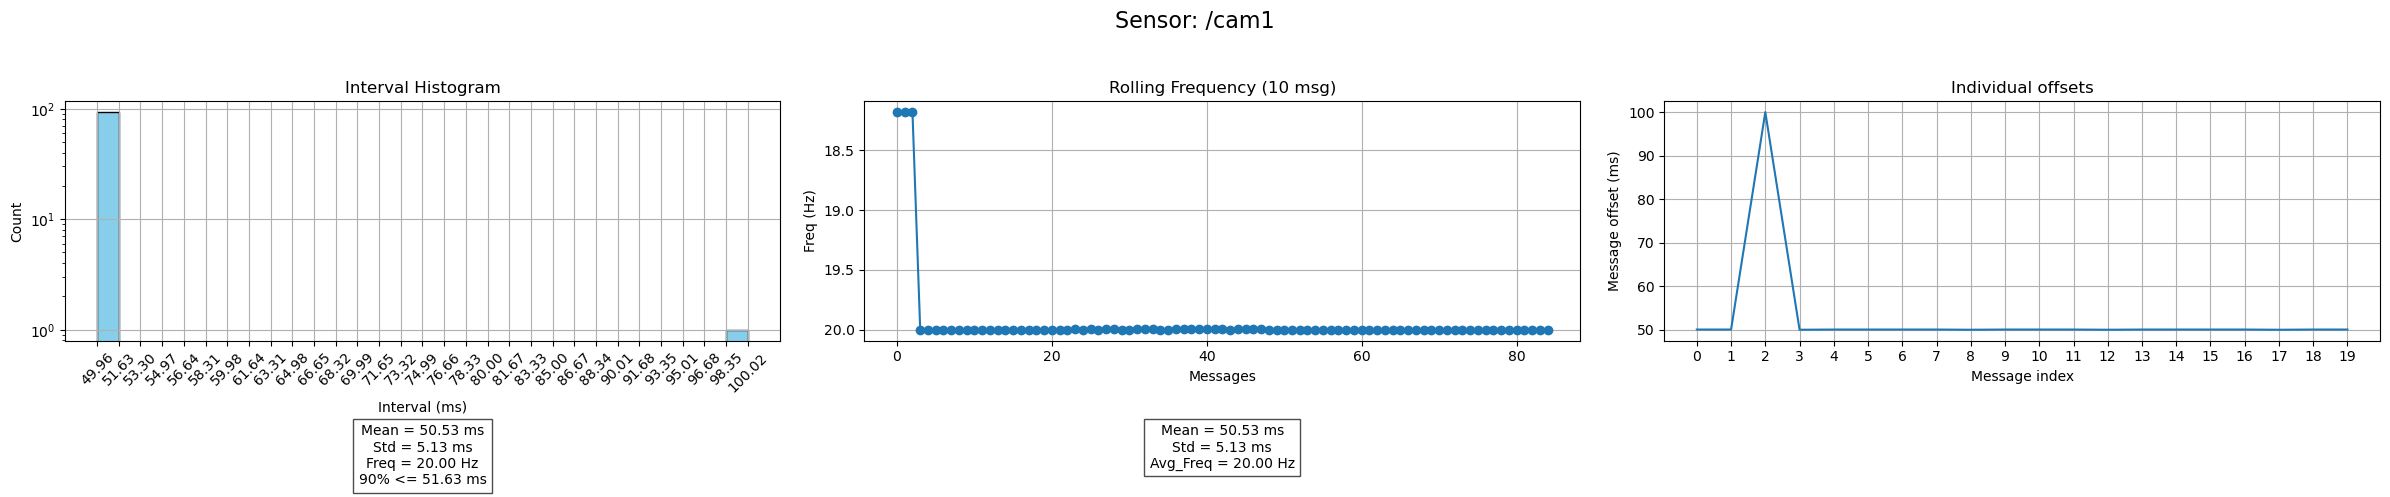

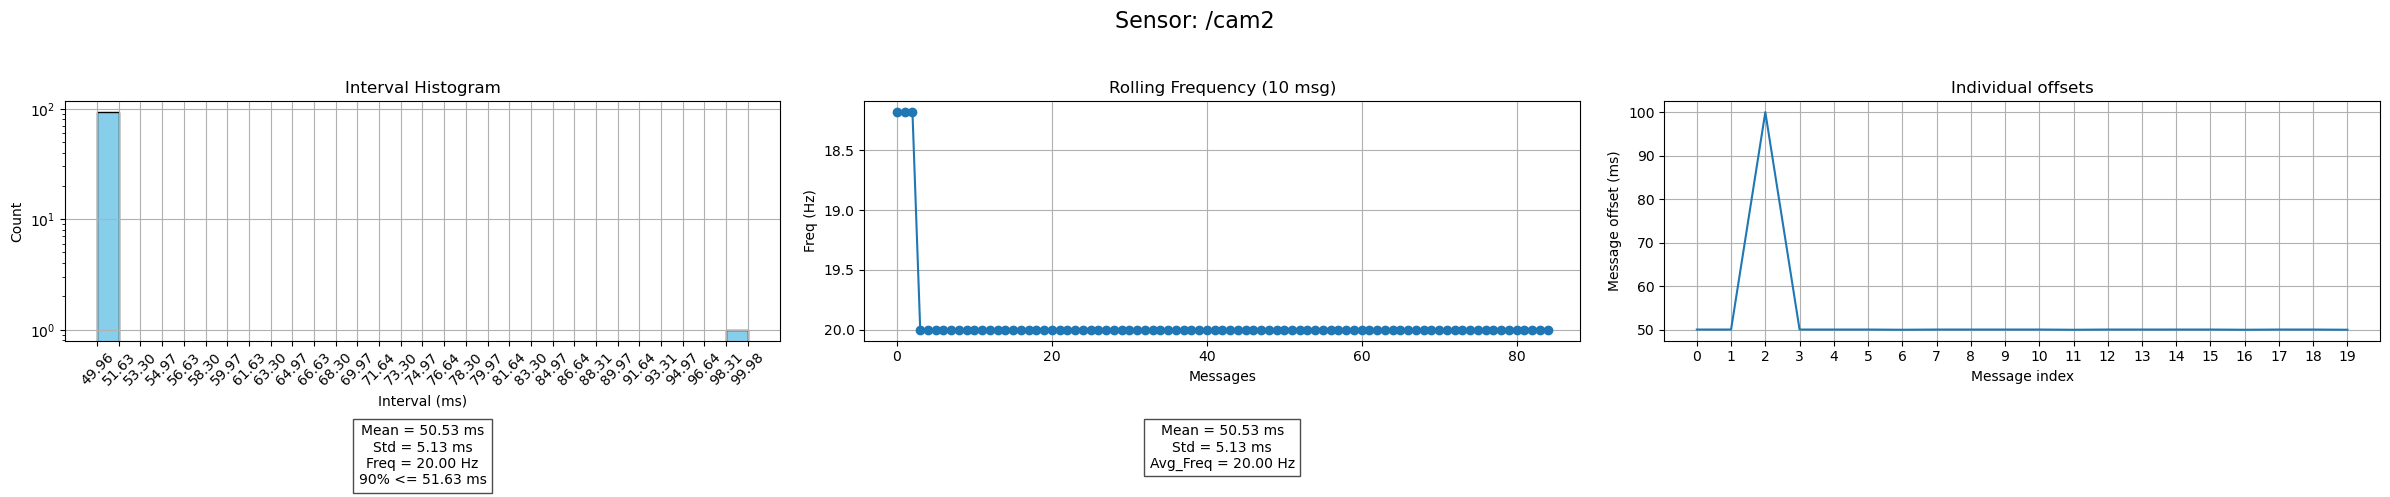

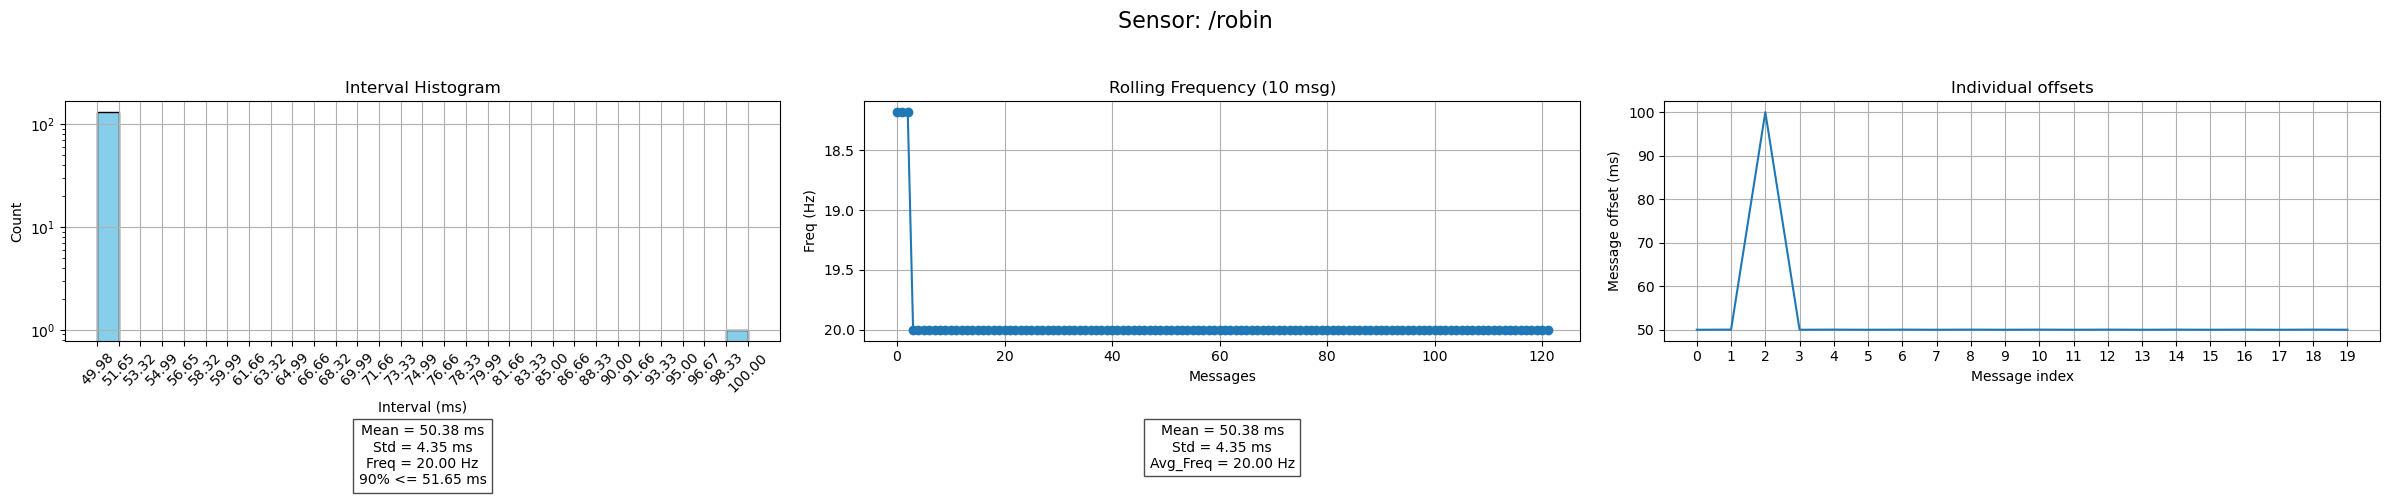

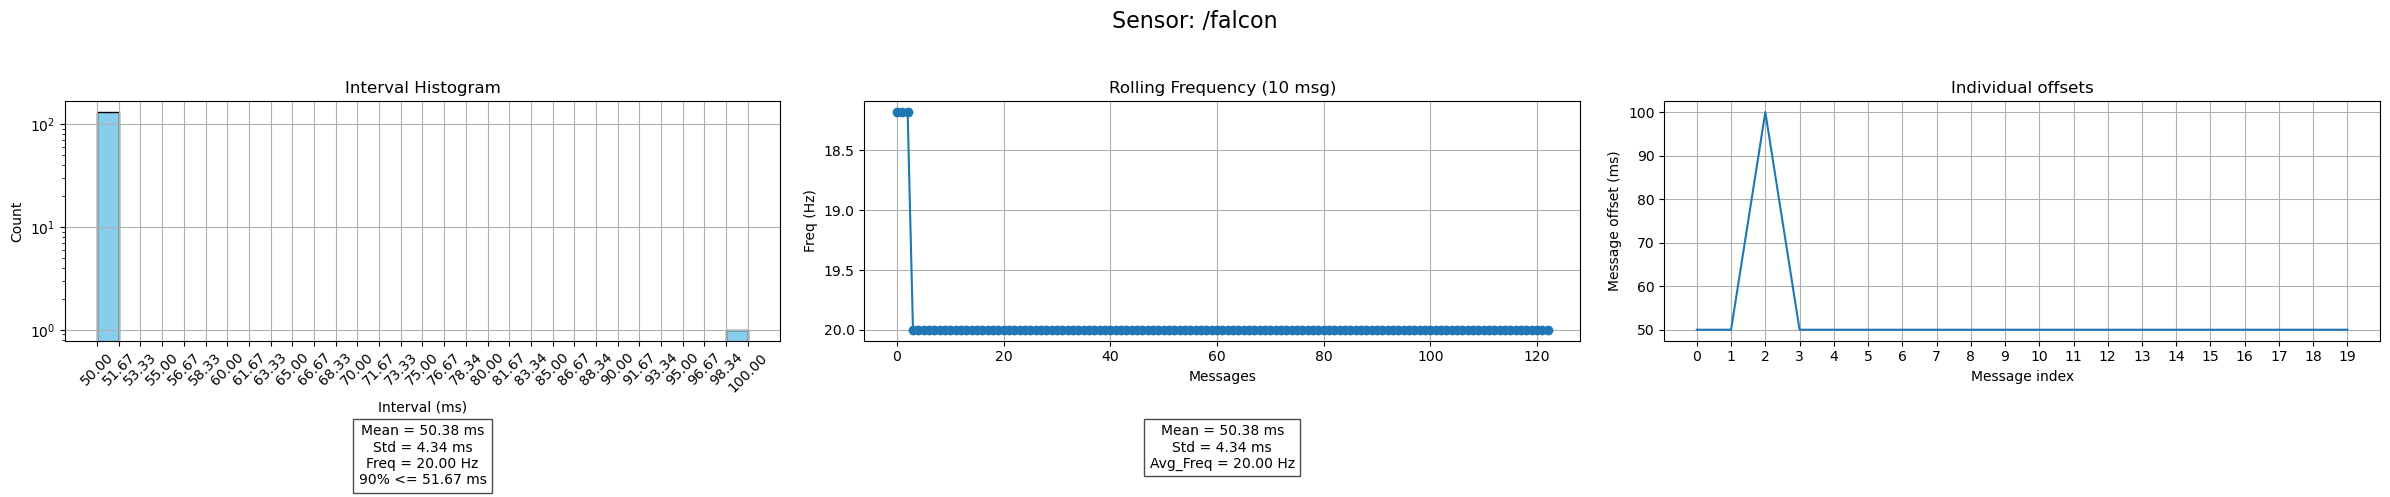

In [33]:
for topic, ts_list in window_stamps.items():
    timestamps = np.array(ts_list)

    index_to_remove = 3  # for example, remove the 4th element
    timestamps = np.delete(timestamps, index_to_remove)
    
    # Convert to milliseconds relative to the first message
    timestamps_ms = np.array([(t - timestamps[0]).total_seconds() * 1000 for t in timestamps])
    
    # Compute inter-message intervals in ms
    deltas = np.diff(timestamps_ms)
    
    # Basic stats
    mean_delta = np.mean(deltas) if len(deltas) > 0 else 0
    std_delta = np.std(deltas) if len(deltas) > 0 else 0
    freq = len(timestamps) / ((timestamps_ms[-1] - timestamps_ms[0])/1000) if len(timestamps) > 1 else 0  # Hz
    
    # CDF calculation
    counts, bin_edges = np.histogram(deltas, bins=30)
    cdf = np.cumsum(counts) / np.sum(counts) * 100
    
    # Percentiles
    percentiles = [90]
    percentile_values = []
    for p in percentiles:
        idx = np.searchsorted(cdf, p)
        interval_value = bin_edges[idx+1] if idx+1 < len(bin_edges) else bin_edges[-1]
        percentile_values.append(interval_value)
    
    # --- Create 3 plots in 1 row ---
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    
    # 1. Histogram of intervals
    if len(deltas) > 0:
        counts, bins, patches = ax[0].hist(deltas, bins=30, color='skyblue', edgecolor='black')
    else:
        ax[0].text(0.5, 0.5, "No data", ha='center', va='center', fontsize=14, color='red')
    ax[0].set_xticks(bins)
    ax[0].set_title("Interval Histogram")
    ax[0].set_xlabel("Interval (ms)")
    ax[0].set_ylabel("Count")
    ax[0].grid(True)
    ax[0].set_yscale('log')
    ax[0].text(0.5, -0.35, f"Mean = {mean_delta:.2f} ms\nStd = {std_delta:.2f} ms\nFreq = {freq:.2f} Hz\n90% <= {percentile_values[0]:.2f} ms",
               transform=ax[0].transAxes, ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    for label in ax[0].get_xticklabels():
       label.set_rotation(45)
    #print(f"{topic} - Histogram: Mean = {mean_delta:.2f} ms, Std = {std_delta:.2f} ms, Freq = {freq:.2f} Hz, 90% <= {percentile_values[0]:.2f} ms")

    
    # 2. Rolling frequency over 10 messages
    if len(deltas) >= 10:
        rolling_freq = 1000 / np.convolve(deltas, np.ones(10)/10, mode='valid')  # Hz
        ax[1].plot(rolling_freq, marker='o', linestyle='-')  # swapped axes
    else:
        ax[1].text(0.5, 0.5, "Not enough data", ha='center', va='center', fontsize=14, color='red')
    
    ax[1].set_title("Rolling Frequency (10 msg)")
    ax[1].set_xlabel("Messages")  # swapped label
    ax[1].set_ylabel("Freq (Hz)")  # swapped label
    ax[1].grid(True)
    ax[1].text(0.5, -0.35, f"Mean = {mean_delta:.2f} ms\nStd = {std_delta:.2f} ms\nAvg_Freq = {freq:.2f} Hz",
               transform=ax[1].transAxes, ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    ax[1].yaxis.set_inverted(True)
    
    #if len(deltas) >= 10:
    #    print(f"{topic} - Rolling Frequency: Mean delta = {mean_delta:.2f} ms, Std delta = {std_delta:.2f} ms, Avg freq = {freq:.2f} Hz")
    #else:
    #    print(f"{topic} - Rolling Frequency: Not enough data for rolling window")
    

    # 3. 
    n = 20 # number of messages to plot
    deltas_to_plot = deltas[:n]
    x = np.arange(len(deltas_to_plot))  # x length matches y
    ax[2].plot(x, deltas_to_plot)
    ax[2].set_xticks(x)
    ax[2].set_xlabel('Message index')
    ax[2].set_ylabel('Message offset (ms)')
    ax[2].grid(True)
    ax[2].set_title("Individual offsets")


    # Layout
    plt.suptitle(f"Sensor: {topic}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

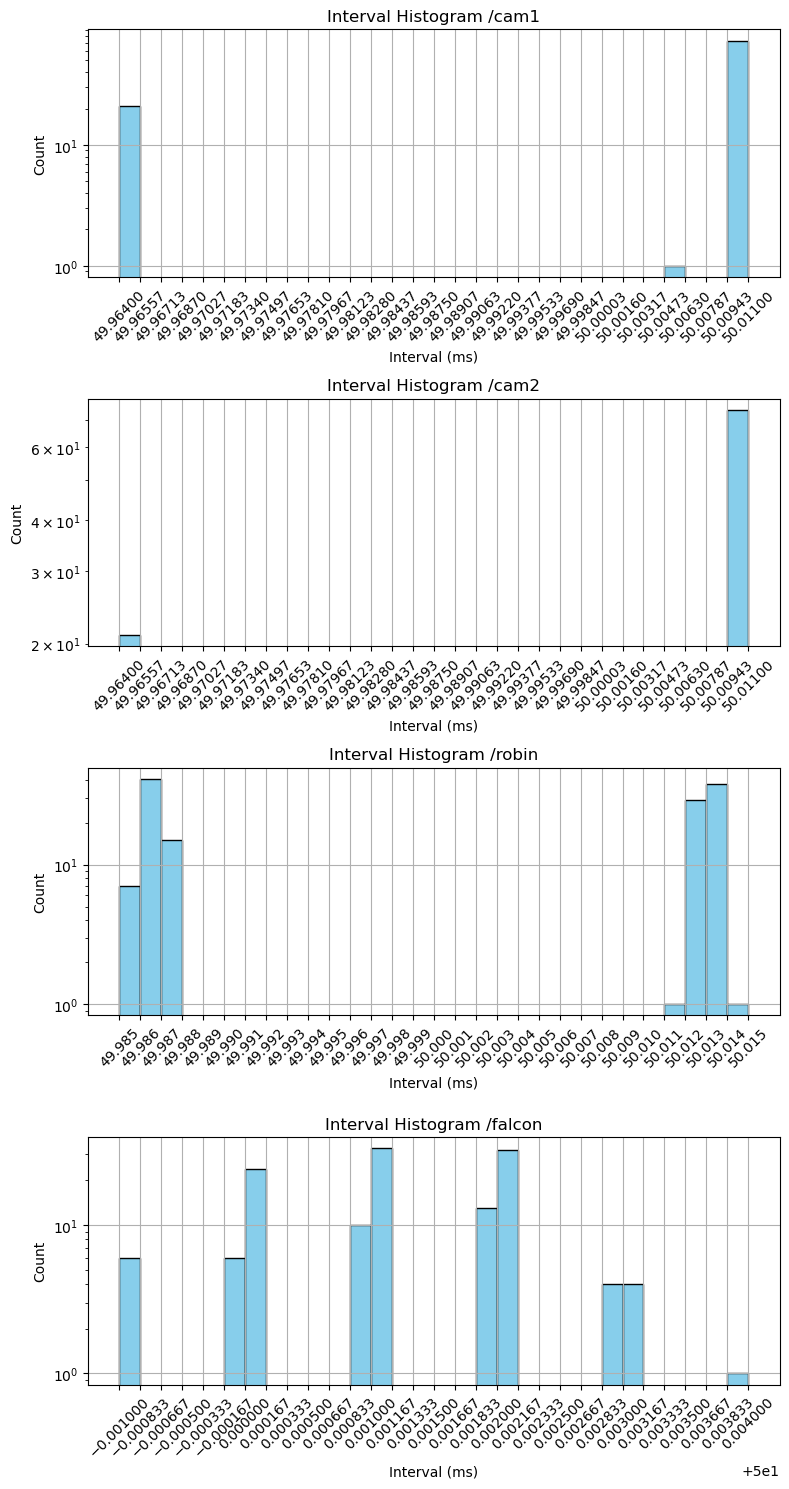

In [34]:
fig, ax = plt.subplots(4, 1, figsize=(8, 15))

for i, (topic, ts_list) in enumerate(window_stamps.items()):
    timestamps = np.array(ts_list)
    
    # Convert to milliseconds relative to the first message
    timestamps_ms = np.array([(t - timestamps[0]).total_seconds() * 1000 for t in timestamps])
    
    # Compute inter-message intervals in ms
    deltas = np.diff(timestamps_ms)
    deltas = deltas[deltas < 60]
    
    # 1. Histogram of intervals
    counts, bins, patches = ax[i].hist(deltas, bins=30, color='skyblue', edgecolor='black')
    ax[i].set_xticks(bins)
    ax[i].set_title(f"Interval Histogram {topic}")
    ax[i].set_xlabel("Interval (ms)")
    ax[i].set_ylabel("Count")
    ax[i].grid(True)
    ax[i].set_yscale('log')
    for label in ax[i].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()


In [35]:
def timestep_deltas(timesteps1, timesteps2, threshold):
    """
    Computes the differences between two arrays of timesteps. Only
    uses timesteps where a match is found within the provided threshold.

    Computes timesteps2 - timesteps1 for each timestep where a match is found

    Args:
        timesteps1 (np.array(datetime)): The first array of timesteps
        timesteps2 (np.array(datetime)): The second array of timesteps
        threshold (int): The number of microseconds between two timesteps for them to be considered a match
    Returns:
        deltas (np.array(int)): The timestep deltas in microseconds
    """
    deltas = []
    for ts in timesteps1:
        # get the closes timestep in timesteps2 to ts
        diffs = timesteps2 - ts # Comupte the deltas between all points in timesteps2 and ts
        diffs = np.array([diff.microseconds for diff in diffs]) # Cast the deltas to microseconds

        # Check if the distance between ts and the closest point in timesteps2 is less than threshold
        abs_diffs = np.abs(diffs) # Use only absolute values, we dont care if the delta is negative
        min_idx = np.argmin(abs_diffs) # Get the index where the distance is minimal, this is the closest point to ts
        if abs_diffs[min_idx] < threshold: # Only consider the two points a match if the distance is less than threshold
            deltas.append(diffs[min_idx])
    return deltas


/tmp/ipykernel_1008813/1856744444.py:9: RuntimeWarning: Mean of empty slice.
  plt.vlines([cam_diffs.mean()], 0, 250, color='red')


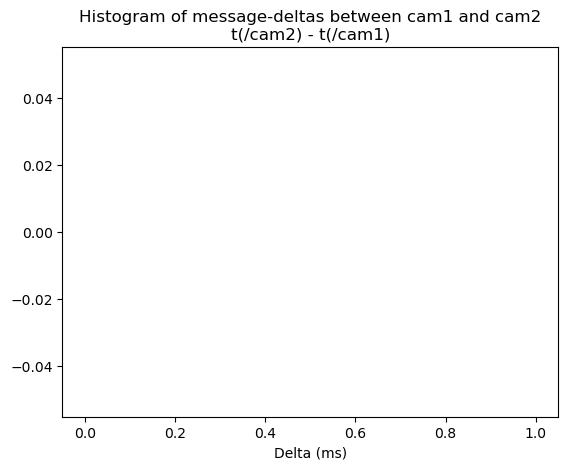

In [38]:
# histogram of deltas for the cameras
threshold = 20000 #μS (microsiemens per centimeter, μS/cm)
cam_diffs = timestep_deltas(window_stamps['/cam1'], window_stamps['/cam2'], threshold)
cam_diffs = np.array(cam_diffs)/1000 # cast to miliseconds

plt.hist(cam_diffs)
plt.xlabel("Delta (ms)")
plt.title("Histogram of message-deltas between cam1 and cam2\nt(/cam2) - t(/cam1)")
plt.vlines([cam_diffs.mean()], 0, 250, color='red')
plt.show()


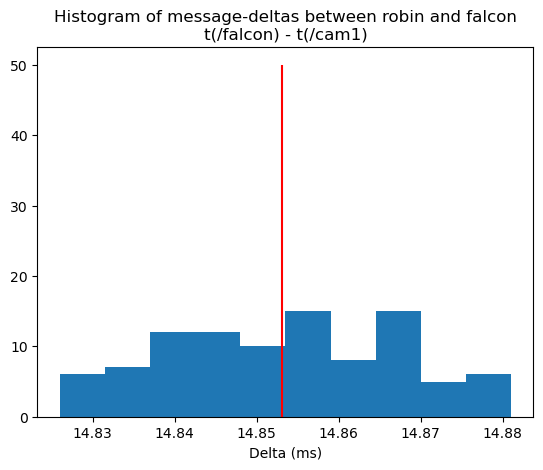

In [37]:
# histogram of deltas for the cameras
threshold = 50000 #μS (microsiemens per centimeter, μS/cm)
cam_diffs = timestep_deltas(window_stamps['/cam1'], window_stamps['/falcon'], threshold)
cam_diffs = np.array(cam_diffs)/1000 # cast to miliseconds

plt.hist(cam_diffs)
plt.xlabel("Delta (ms)")
plt.title("Histogram of message-deltas between robin and falcon\nt(/falcon) - t(/cam1)")
plt.vlines([cam_diffs.mean()], 0, 50 , color='red')


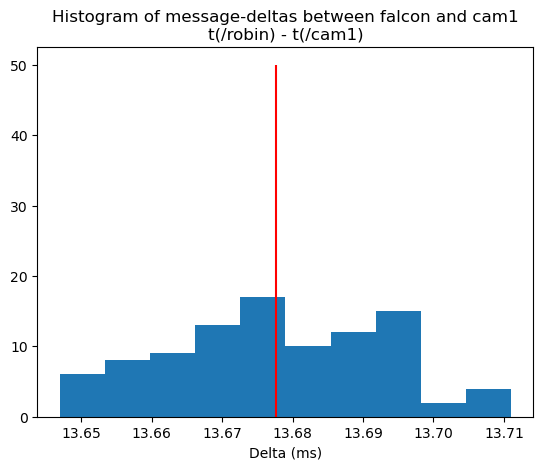

In [21]:
threshold = 50000 #μS (microsiemens per centimeter, μS/cm)
cam_diffs = timestep_deltas(window_stamps['/cam1'], window_stamps['/robin'], threshold)
cam_diffs = np.array(cam_diffs)/1000 # cast to miliseconds

plt.hist(cam_diffs)
plt.xlabel("Delta (ms)")
plt.title("Histogram of message-deltas between falcon and cam1\nt(/robin) - t(/cam1)")
plt.vlines([cam_diffs.mean()], 0, 50, color='red')

Formula: Expected = FPS × window_length [s]
Window length = 15.00 s

╒═════════╤═══════╤═══════════════════╤═════════════════╤══════════════════╕
│ Topic   │   FPS │   Expected Frames │   Actual Frames │ Frame Loss (%)   │
╞═════════╪═══════╪═══════════════════╪═════════════════╪══════════════════╡
│ /cam1   │    30 │               450 │             444 │ 1.33%            │
├─────────┼───────┼───────────────────┼─────────────────┼──────────────────┤
│ /cam2   │    30 │               450 │             431 │ 4.22%            │
├─────────┼───────┼───────────────────┼─────────────────┼──────────────────┤
│ /robin  │    60 │               900 │             872 │ 3.11%            │
├─────────┼───────┼───────────────────┼─────────────────┼──────────────────┤
│ /falcon │    60 │               900 │             886 │ 1.56%            │
╘═════════╧═══════╧═══════════════════╧═════════════════╧══════════════════╛


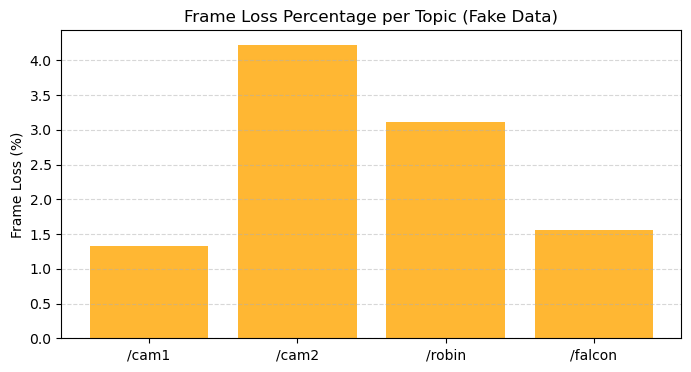

In [22]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np

# --- Fake data ---
topics = ["/cam1", "/cam2", "/robin", "/falcon"]
expected_fps = {"/cam1": 30, "/cam2": 30, "/robin": 60, "/falcon": 60}
window_length = 15  # seconds

# Simulate actual frame counts with some missing frames
np.random.seed(42)  # for reproducible results
window_stamps = {}
for topic in topics:
    f_exp = expected_fps[topic]
    n_expected = int(f_exp * window_length)
    # Simulate missing frames: random number between -5% and 0% of expected frames
    missing = np.random.randint(0, int(0.05 * n_expected))
    n_actual = n_expected - missing
    # Store fake "timestamps" as list (length = n_actual)
    window_stamps[topic] = list(range(n_actual))

# --- Display table ---
rows = []
for topic in window_stamps:
    f_exp = expected_fps[topic]
    n_expected = f_exp * window_length
    n_actual = len(window_stamps[topic])
    loss_percent = (n_expected - n_actual) / n_expected * 100

    rows.append([
        topic,
        f_exp,
        f"{n_expected:.0f}",
        n_actual,
        f"{loss_percent:.2f}%",
    ])

print("Formula: Expected = FPS × window_length [s]")
print(f"Window length = {window_length:.2f} s\n")

print(tabulate(
    rows,
    headers=["Topic", "FPS", "Expected Frames", "Actual Frames", "Frame Loss (%)"],
    tablefmt="fancy_grid"
))

# --- Plot Frame Loss ---
loss_percentages = [(int(row[2]) - int(row[3])) / int(row[2]) * 100 for row in rows]

plt.figure(figsize=(8,4))
plt.bar(topics, loss_percentages, color='orange', alpha=0.8)
plt.ylabel('Frame Loss (%)')
plt.title('Frame Loss Percentage per Topic (Fake Data)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
